- if you don't have conda or anaconda, start by downloading from : https://www.anaconda.com/download 
- create a new anaconda environment to manage libs and dependancies for this project, and name it choir_network `conda create -n choir_network python=3.9`
- y when prompted
- completely close VS code and reopen this folder (recents) - a refresh is needed
- activate the environment `conda activate choir_network`
- in the upper right corner, select the kernel for the notebook `select another > python envs > click on choir_network`
- now conda install stuff. Run `conda install scikit-learn` in the terminal while you see `(choir_network)`, press `y` as needed.
- run your code. If stuff asks to install `ipykernel package` stuff, just say yes
- let's see if u can get past the matplotlib thingy using google

Instructions
 1. Process the Text
 - Convert to Lowercase
 - Remove Punctuation & Numbers
 - Tokenization (Splitting text into individual words or tokens)
 - Removing Stop Words (e.g. "and", "the", "of")
 - Stemming/Lemmatization (reducing words to their base/root form) *optional

 2. Vectorize Text
 - Convert text into numerical format using TF-IDF or embeddings
 - TF-IDF weights the words based on their frequency in a document against their frequency across all documents
 - Word embeddings using Word2Vec, CloVe, or FastText can be used to convert words into vectors (better)

 3. Dimensionality Reduction with t-SNE
 - Choosing parameters (starting point 5 - 50, learning rate 10-1000)
 - Scaling - Might need to scae feature vectors before applying (MinMAxScaler or StandardScaler)
 - Applying t-SNE to reduce dimensionality of vectorized hymns (from scikit-learn)

 4. Visualization
 - Plotting (Matplotlib) to create a scatter plot of 2D points
 - Enhancements to make visualization more informative (optional?)

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [77]:
# Import hymns
hymns = []

def get_hymns(): 
    h = input("Enter the hymn number (1-525). Press enter if finished. ")
    if h:
        hymns.append(int(h))
        get_hymns()
    else:
        return hymns
    
get_hymns()

In [78]:
# 1. Process the Text


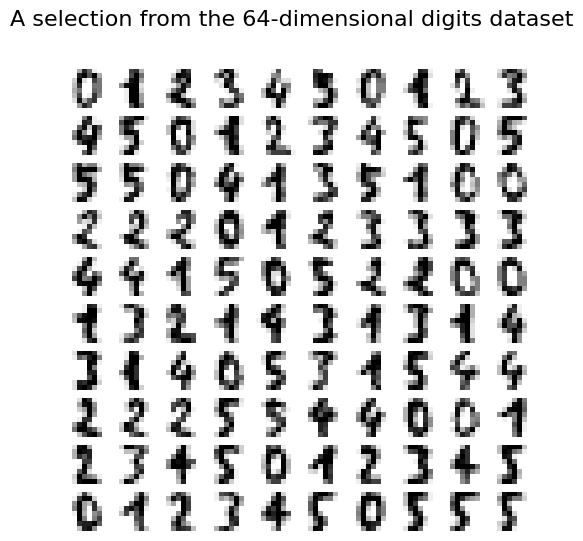

In [79]:
# extra example stuff
from sklearn.datasets import load_digits

digits = load_digits(n_class=6) # they have a built in dataset of numbers from 0 to n_class
X, y = digits.data, digits.target # X is the data (image i believe), y is the correct value/label... I think
n_samples, n_features = X.shape
n_neighbors = 30 # inspect neighbourhood of nearest 30 points 

import matplotlib.pyplot as plt

# print out examples of data
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

In [80]:
# this is a helper function to plot embeddings in a 2D space

import numpy as np
from matplotlib import offsetbox

from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

In [9]:
# this outlines a BUNCH of diff embedding space representations, TSNE is one of them, and you'll later see why it's the best one

from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

embeddings = {
    "t-SNE embedding": TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    )
}

Computing t-SNE embedding...


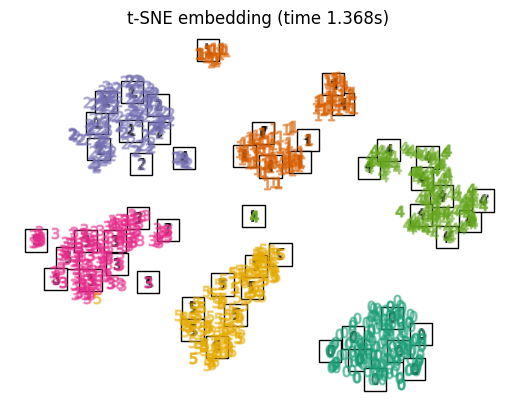

In [82]:
# run it

from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y)
    timing[name] = time() - start_time

for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title)

plt.show()

# Hymn lyric section

In [1]:
#import lyricsgenius
# you will want to run `pip install lyricsgenius` in your terminal,
# again while you see (choir_network) so it means you are adding a library to this environment.
# if pip doesn't work, you need to install pip to conda

#file_path = '/Users/bethanyliu/Desktop/genius.txt' # replace this with wherever the file I gave you is
#token = "x6BMSqzUa..." # it is NEVER good to show api tokens in code.
# In a workplace, it means security issues, and you'd get in trouble.

# read the last line from the important file to get the token, without exposing it to github/public
#try:
#    with open(file_path, 'r') as file:
#        for i, line in enumerate(file, start=1):
#            if i == 6:
#              #  token = line.strip() # set the token as what is in the file, which will be used for the Genius API for lyrics
#                break
#except FileNotFoundError:
#    print(f"The file at {file_path} was not found.")

import os

# function to get lyrics
def get_hymn_lyrics(title):
    file_path = os.path.join("Hymns", f"{title}.txt")
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            lyrics = file.read()
        return lyrics
    else:
        print(f"No lyrics found for '{title}'.") 

print(get_hymn_lyrics("1 All Your Anxiety"))


Is there a heart o'er-bound by sorrow?
Is there a life weighed down by care?
Come to the cross--each burden bearing,
All your anxiety--leave it there.

    All your anxiety, all your care,
    Bring to the mercy seat--leave it there;
    Never a burden He cannot bear,
    Never a friend like Jesus.

No other friend so keen to help you,
No other friend so quick to hear;
No other place to leave your burden,
No other one to hear your prayer.

Come then at once--delay no longer!
Heed His entreaty kind and sweet;
You need not fear a disappointment--
You shall find peace at the mercy seat.


In [84]:
#hymn_title = "Amazing Grace"
#get_hymn_lyrics(hymn_title)
# now let's see if we can just keep things simple, and clean/parse just for verse 1 of every hymn in titles.txt
# Save it in a CSV i guess?
# number,title,verse1,failed_or_not


Searching for "Amazing Grace"...
Done.


"30 ContributorsAmazing Grace Lyrics[Verse 1]\nAmazing Grace, how sweet the sound\nThat saved a wretch like me\nI once was lost but now am found\nWas blind, but now I see\n\n[Verse 2]\nT'was Grace that taught my heart to fear\nAnd Grace, my fears relieved\nHow precious did that Grace appear\nThe hour I first believed\n\n[Verse 3]\nThrough many dangers, toils and snares\nI have already come;\n'Tis Grace that brought me safe thus far\nAnd Grace will lead me home\n\n[Verse 4]\nThe Lord has promised good to me\nHis word my hope secures\nHe will my shield and portion be\nAs long as life endures\n\n[Verse 5]\nYea, when this flesh and heart shall fail\nAnd mortal life shall cease\nI shall possess within the veil\nA life of joy and peace\nYou might also like[Verse 6]\nWhen we've been there ten thousand years\nBright shining as the sun\nWe've no less days to sing God's praise\nThan when we've first begun.10Embed"

In [108]:
# get first verse (we dont need this anymore)
def get_first_verse(title):
    lyrics = get_hymn_lyrics(title)
    try:
        start_index = int(lyrics.find('[Verse 1]'))
        end_index = int(lyrics.find('[Verse 2]'))
        first_verse = lyrics[start_index + len('[Verse 1]'):end_index]
        return first_verse
    except:
        print("No Lyrics Found")
        return 1
    

print(get_hymn_lyrics("Amazing Grace"))

Searching for "Amazing Grace"...
Done.

Amazing Grace, how sweet the sound
That saved a wretch like me
I once was lost but now am found
Was blind, but now I see




In [ ]:
# get lyrics of all hymns (we also dont need this anymore)
import pandas as pd
import time

file_name = "TEMP_titles.txt"
with open(file_name, 'r') as file:
    lines = file.readlines()

Hymns = pd.DataFrame(lines, index=range(1, len(lines)+1))
Hymns = Hymns[0].str.strip()

i = 0
Lyrics = pd.Series(index=Hymns.index)
for title in Hymns:
    try:
        Lyrics[i] = get_first_verse(title)
        i += 1
    except:
        time.sleep(5)
        i += 1

#Hymns['Lyrics'] = Hymns.apply(get_first_verse)

print(Lyrics)



In [20]:
import string
# u gotta pip install stop_words 
from stop_words import get_stop_words

punc_converter = str.maketrans('', '', string.punctuation) # get rid of punctuation
stop_words = get_stop_words('english') # import english stop words

# change to lowercase, remove numbers, removing punctuation (didnt remove numbers cause i dont think there are numbers in hymns)
for hymn in os.listdir("Processed_Hymns"):
    file_path = os.path.join("Processed_Hymns", hymn)

    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            lyrics = file.read()
        
        lyrics_processed = lyrics.lower().translate(punc_converter)
        
        # ig this is tokenization? 
        words = lyrics_processed.split()
        filtered_words = [word for word in words if word not in stop_words] #hehe funny tongue twister
        lyrics_processed = ' '.join(filtered_words)

        with open(file_path, 'w') as file:
            file.write(lyrics_processed)
        print(f"Converted contents of '{hymn}' to lowercase.")


there’s a land of peace and plenty
and its gates are open wide
and the pure in heart and holy
in its shelter may abide
it is not through gates of glory
that a soul must enter in
but all who would find entrance there
must leave the ways of sin

    come over come over
    to the land of corn and wine
    there is nothing can compare
    with the many holy pleasures there
    come over come over
    leave the desert plain below
    and come away away
    come over

there is bread of heaven growing
in its fair and fertile fields
and the wine of love its vineyard
to the thirsting mortal yields
there are mountain heights of glory
that await the trav’ler’s rod
and blest retreats where empty souls
draw nearer unto god

who would stay without its borders
in the desert dark and drear
when the luscious grapes of eschol
are so very very near
enter in then with rejoicing
for the lord is on your side
and in his glorious presence
evermore you shall abide
Converted contents of '44 Come Over.txt' to l

In [24]:
import string
# pip install contractions
import contractions
# u gotta pip install stop_words 
from stop_words import get_stop_words

punc_converter = str.maketrans('', '', string.punctuation.replace('-', '').replace("'", '')) # get rid of punctuation
stop_words = get_stop_words('english') # import english stop words

directory = "Processed_Hymns"
# change to lowercase, remove numbers, removing punctuation (didnt remove numbers cause i dont think there are numbers in hymns)
for hymn in os.listdir(directory):
    file_path = os.path.join(directory, hymn)

    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            lyrics = file.read()
        
        lyrics_processed = contractions.fix(lyrics.lower().translate(punc_converter)).replace("--", " ").replace("-", "")

        with open(file_path, 'w') as file:
            file.write(lyrics_processed)
        print(f"Converted contents of '{hymn}' to lowercase.")

def remove_stop_words():
    words = lyrics_processed.split()
    filtered_words = [word for word in words if word not in stop_words] #hehe funny tongue twister
    lyrics_processed = ' '.join(filtered_words)


Converted contents of '44 Come Over.txt' to lowercase.
Converted contents of '175 He Is Comimg Again.txt' to lowercase.
Converted contents of '220 When I Saw The Cleansing Fountain.txt' to lowercase.
Converted contents of '226 Thy Blessed Will Divine.txt' to lowercase.
Converted contents of '195 Another Year Is Dawning.txt' to lowercase.
Converted contents of '48 Tis So Sweet To Trust.txt' to lowercase.
Converted contents of '105 I'll Tell The World.txt' to lowercase.
Converted contents of '260 Gracious Spirit Dwell With Me.txt' to lowercase.
Converted contents of '117 Show A Little Bit Of Love And Kindness.txt' to lowercase.
Converted contents of '61 Lord Speak To Me.txt' to lowercase.
Converted contents of '189 Take Time To Be Holy.txt' to lowercase.
Converted contents of '205 Have You Counted The Cost.txt' to lowercase.
Converted contents of '43 Trust And Obey.txt' to lowercase.
Converted contents of '47 Just Obey.txt' to lowercase.
Converted contents of '58 The Last Mile Of The Way